In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import warnings

import keras
from keras import layers
from keras import ops
from keras.models import load_model
from keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
from keras.optimizers import Adam
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

2024-11-25 14:44:26.404828: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 14:44:26.413929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732542266.424299    1282 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732542266.427185    1282 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 14:44:26.437546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_global_policy(policy)

Num GPUs Available:  1


In [3]:
#Load relevant databases
df_movies = pd.read_csv("../data/movies.csv", index_col = 0)
df = pd.read_csv("../data/ratings.csv") 

In [4]:
#preprocessing
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 138493, Number of Movies: 26744, Min rating: 0.5, Max rating: 5.0


In [5]:
#Prepare training and validation data
x = df[["user", "movie"]]
# Normalize the targets between 0 and 1. Makes it easy to train. Target is around 0.1 MAE
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
#Target Variable, Rating from 0.5 - 5.0. Target is around 0.5 MAE
#y = df["rating"]
# Splitting into train and test set, 20% test set
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)
x_train = [x_train["user"], x_train["movie"]]
x_test = [x_test["user"], x_test["movie"]]

In [ ]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(num_users, 100, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

movie_input = Input(shape=[1], name="Movie-Input")
movie_embedding = Embedding(num_movies, 100, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)


#genome_embedding = Embedding(
conc = Concatenate()([user_vec, movie_vec])

# add fully-connected-layers
fc1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(conc)
fc1 = Dropout(0.1)(fc1)  # Dropout with 10% rate
fc1 = BatchNormalization()(fc1)
fc2 = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(fc1)
fc2 = Dropout(0.1)(fc2)  # Dropout with 10% rate
fc2 = BatchNormalization()(fc2)
out = Dense(1)(fc2)
# Create model and compile it
model = Model([user_input, movie_input], out)
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    loss="mean_absolute_error",
    optimizer=optimizer,
)

In [ ]:
#Train the model based on the data split
#loss after 25 epochs:loss: 0.5786 - val_loss: 0.6094 (MAE)
#after 25 it starts overfitting and val_loss doesnt go down

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

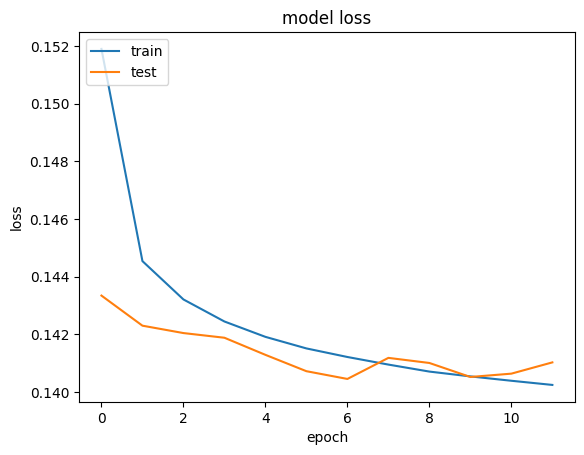

KeyError: 'accuracy'

In [22]:
#Plot training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

#Plot training and validation accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
#Show top 10 movie recommendations to a user
movie_df = pd.read_csv(movielens_dir / "movies.csv")
#movies_df = pd.read_csv("./ml-20m/movies.csv") #use this one for local data 20m movie database

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

In [ ]:
#saving the model
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(LOCAL_DIR, f"ai-model/model/{version}")
print('export_path = {}\\n'.format(export_path))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)